<a href="https://colab.research.google.com/github/sai-teja-ponugoti/Brain-Tumor-Segmentation/blob/main/dev_BRATS_uNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # #uploading kaggle json file 
from google.colab import files
import io
uploaded = files.upload()

# Let's make sure the kaggle.json file is present.
# how to upload dataset in google colab from kaggle:  https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab

!ls -lha kaggle.json 

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Untitled15
# kaggle datasets download -d iarunava/cell-images-for-detecting-malaria


# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#downloading the dataset from kaggle
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# !kaggle competitions download -c aptos2019-blindness-detection

#unzipping the dataset
!unzip lgg-mri-segmentation


Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [37]:
import numpy as np
import pandas as pd
import os
import time
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def getImagePaths(data_path):
    masks_paths = []

    for dir in os.listdir(data_path):
        # excluding readme and data.csv files as they are not used in training
        if dir not in ['README.md', 'data.csv']:
            for file_path in os.listdir(os.path.join(data_path,dir)):
                if '_mask' in file_path:
                    masks_paths.append(os.path.join(data_path,dir,file_path))

    # replacing '_mask' in masks path to get image paths
    image_paths = [path.replace("_mask",'') for path in masks_paths]
    
    print("Total number of images found: ",len(image_paths))
    print("Total number of masks found: ",len(image_paths))
    
    # converting to dataframe as flow_from_dataframe requires dataframe as input
    return pd.DataFrame({"images": image_paths}), pd.DataFrame({"masks":masks_paths})

In [3]:
def displayImageMask(image_paths, masks_paths, num_image_pairs):
    print("Displaying random image and mask pairs")
    for i in random.sample(range(0, len(image_paths)), num_image_pairs):
#         print(image_paths["images"][i])
#         print(masks_paths["masks"][i])
        image = Image.open(image_paths["images"][i])
        mask = Image.open(masks_paths["masks"][i])
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
        ax1.imshow(image)
        ax2.imshow(mask)
        

In [4]:
def splitData(image_paths, masks_paths, test_size=0.2, random_state=42):
    # splitting the data into train and validation sets
    return train_test_split(image_paths, masks_paths, test_size = test_size, random_state = random_state)

In [5]:
# def dataGenCreator(images, masks, args_dict, image_col, paths_col):
    
#     # Provide the same seed and keyword arguments to the fit and flow methods
#     seed = 1

#     image_datagen = ImageDataGenerator(**args_dict)
#     mask_datagen = ImageDataGenerator(**args_dict)

#     image_generator = image_datagen.flow_from_dataframe(images, x_col = image_col, class_mode=None,seed=seed)

#     mask_generator = mask_datagen.flow_from_dataframe(masks, x_col = paths_col, class_mode=None, seed=seed)

#     # combine generators into one which yields image and masks
#     return zip(image_generator, mask_generator)

def dataGenCreator(images, masks, args_dict, image_col, paths_col):
    
    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1

    image_datagen = ImageDataGenerator(rescale=1/255,**args_dict)
    mask_datagen = ImageDataGenerator(rescale=1/255,**args_dict)

    image_generator = image_datagen.flow_from_dataframe(
        images,
        x_col = image_col,
        batch_size=32,
        target_size = (256,256),
        color_mode = "rgb",
        class_mode=None,
        seed=seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        masks, 
        x_col = paths_col, 
        batch_size=32,
        target_size = (256,256),
        color_mode = "grayscale",
        class_mode=None, 
        seed=seed)

    # combine generators into one which yields image and masks
    return zip(image_generator, mask_generator)
        

Total number of images found:  3929
Total number of masks found:  3929
Displaying random image and mask pairs
Size of train set:  2828
Size of validation set:  708
Size of test set:  393
Train data generator:-
Found 2828 validated image filenames.
Found 2828 validated image filenames.
Validation data generator:-
Found 708 validated image filenames.
Found 708 validated image filenames.
Test data generator:-
Found 393 validated image filenames.
Found 393 validated image filenames.


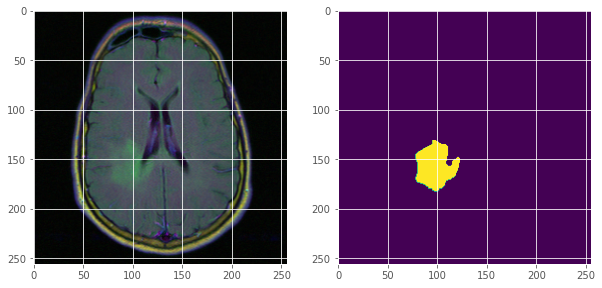

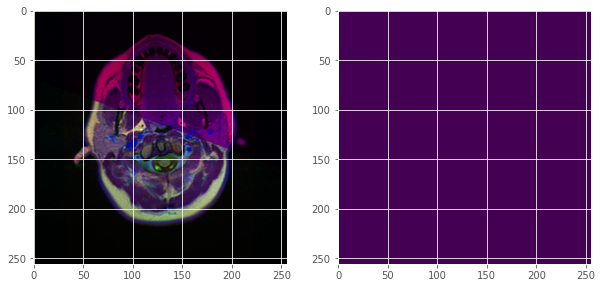

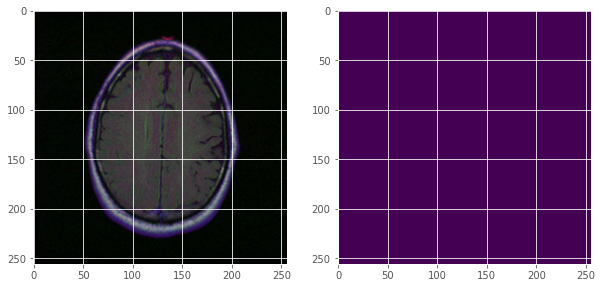

In [14]:
data_path = "/content/kaggle_3m"

image_paths, masks_paths = getImagePaths(data_path)

displayImageMask(image_paths,masks_paths, 3)

train_images, test_images , train_masks, test_masks  = splitData(image_paths, masks_paths, test_size = 0.1)
train_images, val_images, train_masks, val_masks = splitData(train_images, train_masks, test_size = 0.2)

print("Size of train set: ",train_images.shape[0])
print("Size of validation set: ",val_images.shape[0])
print("Size of test set: ",test_images.shape[0])


# we create two instances with the same arguments
data_gen_args = dict(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2)

print("Train data generator:-")
train_data_generator = dataGenCreator(train_images, train_masks, data_gen_args, "images", "masks")
print("Validation data generator:-")
validation_data_generator = dataGenCreator(val_images, val_masks, data_gen_args, "images", "masks")
print("Test data generator:-")
test_data_generator = dataGenCreator(test_images, test_masks, data_gen_args, "images", "masks")

In [15]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return 1 - iou(y_true, y_pred)




In [32]:
class UNetModel:

    def __init__(self, input_size, n_filters=16, dropout=0.1, batchnorm=True, pooling_size=2, kernel_size=3):
        self.input_size = input_size
        self.n_filters = n_filters
        self.dropout = dropout
        self.batchnorm = batchnorm
        self.pooling_size = pooling_size
        self.kernel_size = kernel_size

    def conv2d_block(self, input_tensor, n_filters, kernel_size=3, batchnorm=True):
        """Function to add 2 convolutional layers with the parameters passed to it
        :param input_tensor: input layer
        :param n_filters: number of filters to be used in Conv layers
        :param kernel_size: Kernel size to be used in conv layers
        :param batchnorm: boolean variable to enable or disable batchnorm
        :return: pair of conv layers as part of u-net architecture
        """
        # first layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal',
                   padding='same')(input_tensor)
        # if batchnorm:
        #     x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal',
                   padding='same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x

    def get_unet(self):
        """Function to define the UNET Model"""
        # Contracting Path
        inputs = Input(self.input_size)

        c1 = self.conv2d_block(inputs, self.n_filters * 1, kernel_size=self.kernel_size, batchnorm=self.batchnorm)
        p1 = MaxPooling2D(pool_size=(self.pooling_size, self.pooling_size))(c1)

        c2 = self.conv2d_block(p1, self.n_filters * 2, kernel_size=self.kernel_size, batchnorm=self.batchnorm)
        p2 = MaxPooling2D(pool_size=(self.pooling_size, self.pooling_size))(c2)

        c3 = self.conv2d_block(p2, self.n_filters * 4, kernel_size=self.kernel_size, batchnorm=self.batchnorm)
        p3 = MaxPooling2D(pool_size=(self.pooling_size, self.pooling_size))(c3)

        c4 = self.conv2d_block(p3, self.n_filters * 8, kernel_size=self.kernel_size, batchnorm=self.batchnorm)
        p4 = MaxPooling2D(pool_size=(self.pooling_size, self.pooling_size))(c4)

        c5 = self.conv2d_block(p4, self.n_filters * 16, kernel_size=self.kernel_size, batchnorm=self.batchnorm)

        # Expansive Path
        up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5), c4], axis=3)
        c6 = self.conv2d_block(up6, self.n_filters * 8, kernel_size=self.kernel_size, batchnorm=self.batchnorm)

        up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6), c3], axis=3)
        c7 = self.conv2d_block(up7, self.n_filters * 4, kernel_size=self.kernel_size, batchnorm=self.batchnorm)

        up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7), c2], axis=3)
        c8 = self.conv2d_block(up8, self.n_filters * 2, kernel_size=self.kernel_size, batchnorm=self.batchnorm)

        up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8), c1], axis=3)
        c9 = self.conv2d_block(up9, self.n_filters * 1, kernel_size=self.kernel_size, batchnorm=self.batchnorm)

        c10 = Conv2D(1, (1, 1), activation='sigmoid')(c9)

        return Model(inputs=[inputs], outputs=[c10])

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def dataGenCreator(images, masks, args_dict, image_col, paths_col, batch_size, target_size):
    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1

    image_datagen = ImageDataGenerator(rescale=1 / 255, **args_dict)
    mask_datagen = ImageDataGenerator(rescale=1 / 255, **args_dict)

    image_generator = image_datagen.flow_from_dataframe(
        images,
        x_col=image_col,
        batch_size=batch_size,
        target_size=target_size,
        color_mode="rgb",
        class_mode=None,
        seed=seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        masks,
        x_col=paths_col,
        batch_size=batch_size,
        target_size=target_size,
        color_mode="grayscale",
        class_mode=None,
        seed=seed)

    # combine generators into one which yields image and masks
    return zip(image_generator, mask_generator)



In [39]:
# unet = UNetModel(input_size=(256,256,3), n_filters=64, dropout=0.1, batchnorm=True, pooling_size=2, kernel_size=3)

In [40]:
# unetModel = unet.get_unet()

In [41]:
# unetModel.summary()

In [38]:
from keras import backend as K
import os
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


class Train:

    def __init__(self, model, learning_rate, epochs, batch_size, model_dest_path, train_data_generator,
                 len_train_images, len_val_images,val_data_generator, smooth=100):
        self.model = model
        self.learning_rate = learning_rate
        self.model_dest_path = model_dest_path
        self.train_data_generator = train_data_generator
        self.val_data_generator = val_data_generator
        self.batch_size = batch_size
        self.smooth = smooth
        self.epochs = epochs
        self.len_train_images = len_train_images
        self.len_val_images = len_val_images
        self.callbacks = [
            ModelCheckpoint(os.path.join(model_dest_path, 'unet_brain_mri_seg.hdf5'), verbose=1, save_best_only=True)]

    def plotGraph(self, type_of_graph, path):
        plt.plot(self.history.history[type_of_graph])
        plt.plot(self.history.history['val_' + type_of_graph])
        plt.title('model ' + type_of_graph)
        plt.ylabel(type_of_graph)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        # plt.show()
        plt.savefig(os.path.join(path, type_of_graph + '_graph.png'))

    def dice_coef(self, y_true, y_pred):
        """
        Dice = (2*|X & Y|)/ (|X|+ |Y|)
            =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
        """
        y_truef = K.flatten(y_true)
        y_predf = K.flatten(y_pred)
        And = K.sum(y_truef * y_predf)
        return (2 * And + self.smooth) / (K.sum(y_truef) + K.sum(y_predf) + self.smooth)

    def dice_coef_loss(self, y_true, y_pred):
        return 1 - self.dice_coef(y_true, y_pred)

    def iou(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred)
        sum_ = K.sum(y_true + y_pred)
        jac = (intersection + self.smooth) / (sum_ - intersection + self.smooth)
        return jac

    def jac_distance(self, y_true, y_pred):
        """
        Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
                = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

        The jaccard distance loss is usefull for unbalanced datasets. This has been
        shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
        gradient.
        """
        return 1 - self.iou(y_true, y_pred)

    def save_model(self, dest_path):
        self.model.save(dest_path)

    def optimizer(self):
        return Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None,
                    decay=self.learning_rate / self.epochs, amsgrad=False)

    def train(self):
        self.model.compile(optimizer=self.optimizer(), loss=self.dice_coef_loss,
                           metrics=["binary_accuracy", self.iou, self.dice_coef, self.jac_distance])

        self.history = self.model.fit(self.train_data_generator,
                                      steps_per_epoch=self.len_train_images / self.batch_size,
                                      epochs=self.epochs,
                                      callbacks=self.callbacks,
                                      validation_data=self.validation_data_generator,
                                      validation_steps=self.len_val_images / self.batch_size)

        self.model.save(os.path.join(self.model_dest_path, "ctModel"))

        self.plotGraph("binary_accuracy", self.model_dest_path)
        self.plotGraph("dice_coef", self.model_dest_path)
        self.plotGraph("iou", self.model_dest_path)
        self.plotGraph("jac_distance", self.model_dest_path)


In [ ]:
# import os
# from experiment import Train
# from model import uNetModel
# from data_handler import DataHandler

INPUT_SIZE = (256,256,3)
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 144
N_FILTERS = 64
DROPOUT = 0.1
BATCHNORM = True
POOLING_SIZE = 2
KERNEL_SIZE = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 4
EPOCHS = 25

# absolute path of folder till PART 1 in coding exam folder
PATH = ""
MODEL_SAVE_PATH = os.path.join(PATH,'models')

print("Train data generator:-")
train_data_generator = dataGenCreator(train_images, train_masks, data_gen_args, "images", "masks")
print("Validation data generator:-")
validation_data_generator = dataGenCreator(val_images, val_masks, data_gen_args, "images", "masks")
print("Test data generator:-")
test_data_generator = dataGenCreator(test_images, test_masks, data_gen_args, "images", "masks")

# create a unet model with required hyper parameters
unetModel = uNetModel(INPUT_SIZE, n_filters=N_FILTERS, dropout=DROPOUT,
                        batchnorm=BATCHNORM)

unet = UNetModel(input_size=INPUT_SIZE, N_FILTERS=64, dropout=DROPOUT, batchnorm=BATCHNORM, pooling_size=POOLING_SIZE, kernel_size=KERNEL_SIZE)
unetModel = unet.get_unet()
# creating a train object to train the network
trainObj = Train(model=unetModel, learning_rate=LEARNING_RATE, model_dest_path=MODEL_SAVE_PATH,
                    train_data=dataObject.train_data_images,
                    train_masks=dataObject.train_label_images, val_data=dataObject.validation_data_images,
                    val_masks=dataObject.validation_label_images, batch_size=BATCH_SIZE)

Train(model=unetModel,  learning_rate=LEARNING_RATE, epochs= EPOCHS, batch_size= BATCH_SIZE, model_dest_path=MODEL_SAVE_PATH, train_data_generator=train_data_generator,
                 len_train_images,validation_data_generator=validation_data_generator, len_val_images, smooth=100)

trainObj.train()

In [47]:
len(list(train_data_generator)[0])

KeyboardInterrupt: ignored

In [36]:
# # model = unet(input_size=(256, 256, 3))

# learning_rate = 0.001
# EPOCHS = 10
# BATCH_SIZE = 32

# def optimizer(learning_rate, epochs):
#     return Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay= learning_rate / EPOCHS, amsgrad=False)


# unetModel.compile(optimizer= optimizer(learning_rate, EPOCHS), loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef, jac_distance])

# callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

# history = unetModel.fit(train_data_generator,
#                     steps_per_epoch=len(train_images) / BATCH_SIZE, 
#                     epochs=EPOCHS, 
#                     callbacks=callbacks,
#                     validation_data = validation_data_generator,
#                     validation_steps=len(val_images) / BATCH_SIZE)

Epoch 1/10
88/88 [==============================] - 162s 2s/step - loss: -0.1426 - binary_accuracy: 0.9215 - iou: 0.0799 - dice_coef: 0.1427 - jac_distance: -0.0799 - val_loss: -0.0297 - val_binary_accuracy: 0.2908 - val_iou: 0.0147 - val_dice_coef: 0.0289 - val_jac_distance: -0.0147

Epoch 00001: val_loss improved from inf to -0.02973, saving model to unet_brain_mri_seg.hdf5
Epoch 2/10
88/88 [==============================] - 158s 2s/step - loss: -0.5011 - binary_accuracy: 0.9886 - iou: 0.3447 - dice_coef: 0.5011 - jac_distance: -0.3447 - val_loss: -0.0511 - val_binary_accuracy: 0.5666 - val_iou: 0.0282 - val_dice_coef: 0.0544 - val_jac_distance: -0.0282

Epoch 00002: val_loss improved from -0.02973 to -0.05107, saving model to unet_brain_mri_seg.hdf5
Epoch 3/10
88/88 [==============================] - 158s 2s/step - loss: -0.5924 - binary_accuracy: 0.9920 - iou: 0.4305 - dice_coef: 0.5924 - jac_distance: -0.4305 - val_loss: -0.0944 - val_binary_accuracy: 0.7974 - val_iou: 0.0500 - va

In [23]:
    def plotGraph(history, type_of_graph, path):
        plt.plot(history.history[type_of_graph])
        plt.plot(history.history['val_' + type_of_graph])
        plt.title('model '+ type_of_graph)
        plt.ylabel(type_of_graph)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        # plt.show()
        plt.savefig(os.path.join(path, type_of_graph + '_graph.png'))

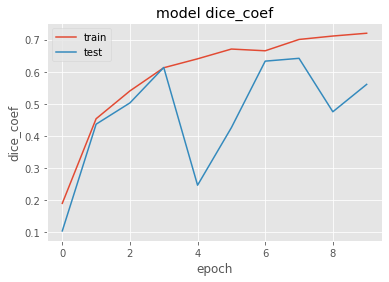

In [27]:
plotGraph(history,"dice_coef",'' )
# plotGraph(history,"val_dice_coef",'' )


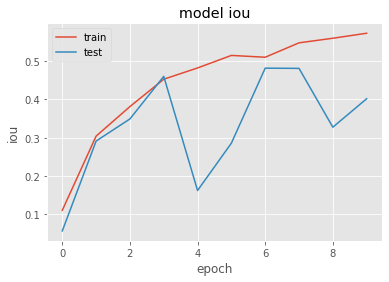

In [28]:
plotGraph(history,"iou",'' )
# plotGraph(history,"val_iou",'' )


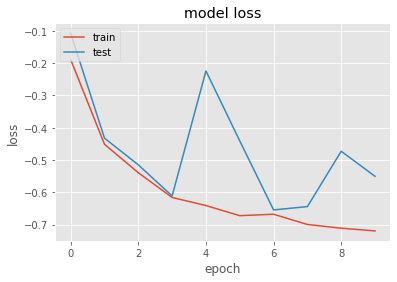

In [29]:
plotGraph(history,"loss",'' )
# plotGraph(history,"val_loss",'' )

In [12]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

KeyError: ignored